In [3]:
!pip install -c rapidsai -c nvidia -c conda-forge \
    cuml=24.02 python=3.10 cudatoolkit=11.8

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'rapidsai'


In [2]:
import numpy as np
import pandas as pd
import os
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# RAPIDS cuML GPU SVM
from cuml.svm import SVC as cuSVC

In [5]:
# ---- Load Data ----
path=kagglehub.dataset_download("siddharthss/crop-recommendation-dataset")
data = os.path.join(path, "Crop_recommendation.csv")
df = pd.read_csv(data)

In [6]:
# Features & labels
X = df[['N','P','K','temperature','humidity','ph','rainfall']]
le = LabelEncoder()
y = le.fit_transform(df['label'])

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
import cupy as cp
# Convert to GPU arrays
X_train_gpu = cp.array(X_train.values)
y_train_gpu = cp.array(y_train)
X_test_gpu = cp.array(X_test.values)
y_test_gpu = cp.array(y_test)

# Check number of classes
num_classes = len(cp.unique(y_train_gpu))

# Train a One-vs-Rest SVM manually for multi-class
svm_models = {}
y_pred_gpu = cp.zeros(y_test_gpu.shape, dtype=cp.int32)

for cls in range(num_classes):
    y_binary = (y_train_gpu == cls).astype(cp.int32)
    model = cuSVC(kernel='rbf', probability=False, random_state=42)
    model.fit(X_train_gpu, y_binary)
    svm_models[cls] = model

# Predict
votes = cp.zeros((X_test_gpu.shape[0], num_classes))
for cls, model in svm_models.items():
    pred = model.predict(X_test_gpu)
    votes[:, cls] = pred

y_pred_gpu = cp.argmax(votes, axis=1)

# Back to CPU
y_pred = cp.asnumpy(y_pred_gpu)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9136363636363637


In [9]:
import cudf
from cuml.svm import SVC as cuSVC
from sklearn.metrics import accuracy_score

X_train_gpu = cudf.DataFrame.from_pandas(X_train)
X_test_gpu  = cudf.DataFrame.from_pandas(X_test)
y_train_gpu = cudf.Series(y_train)
y_test_gpu  = cudf.Series(y_test)

svm_model_gpu = cuSVC(kernel='rbf', C=1.0, gamma='scale')
svm_model_gpu.fit(X_train_gpu, y_train_gpu)
y_pred_gpu = svm_model_gpu.predict(X_test_gpu)

y_pred = y_pred_gpu.to_pandas()
accuracy = accuracy_score(y_test, y_pred)
print("GPU Test Accuracy:", accuracy)


GPU Test Accuracy: 0.9795454545454545


In [10]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print("GPU SVM Accuracy:", accuracy)

print("--- Evaluation: GPU RBF Kernel SVM ---")
print(classification_report(y_test, y_pred, target_names=sorted(df['label'].unique())))

GPU SVM Accuracy: 0.9795454545454545
--- Evaluation: GPU RBF Kernel SVM ---
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.91      1.00      0.95        20
      grapes       1.00      1.00      1.00        20
        jute       0.77      1.00      0.87        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       1.00      0.90      0.95        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
     

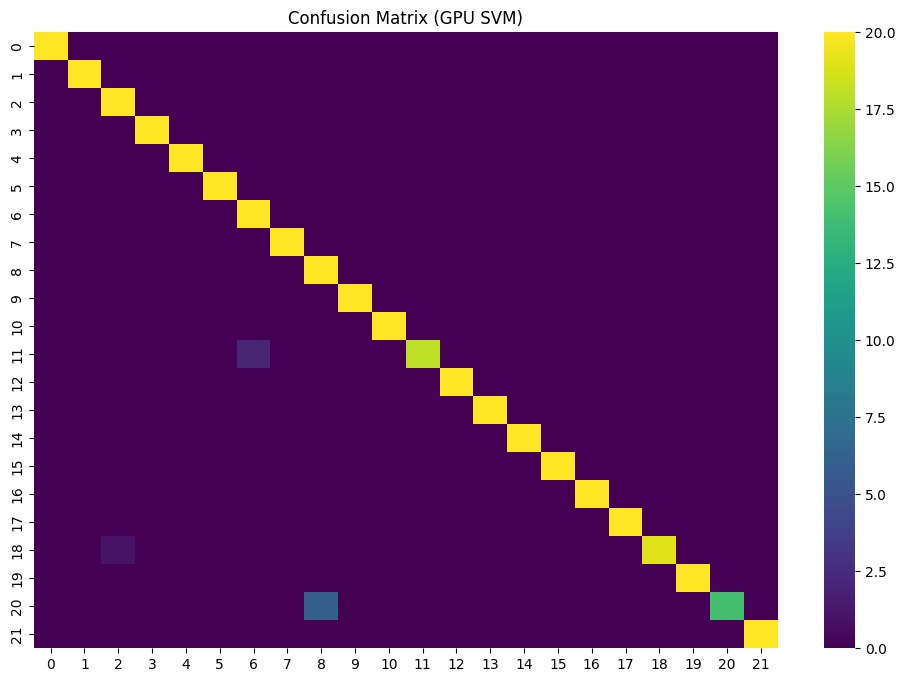

In [11]:
# Confusion Matrix
plt.figure(figsize=(12,8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=False, cmap="viridis")
plt.title("Confusion Matrix (GPU SVM)")
plt.show()


In [12]:
import cudf
import pandas as pd

# ---- Test with Sample ----
sample = pd.DataFrame([[90, 40, 40, 25, 70, 6.5, 200]],
                      columns=['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'])

# Convert to cuDF for GPU prediction
sample_gpu = cudf.DataFrame.from_pandas(sample)

# Predict using GPU SVM
pred_encoded_gpu = svm_model_gpu.predict(sample_gpu)

# Convert prediction to NumPy array for LabelEncoder
pred_encoded = pred_encoded_gpu.to_pandas().astype(int)

# Decode label
pred_crop = le.inverse_transform(pred_encoded)
print("Recommended Crop:", pred_crop[0])


Recommended Crop: jute
